In [2]:
import numpy as np
import slideio
import cv2
import json
import matplotlib.path as mpltPath
import os
import warnings
import tifffile
from skimage import exposure
from skimage.exposure import match_histograms
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image
from math import sqrt
import matplotlib.pyplot as plt
from glob import glob
from copy import copy
from tqdm.notebook import tqdm
import warnings
import staintools

# 경고 메시지를 무시하도록 설정s
warnings.filterwarnings("ignore")
def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [3]:
protein_expression_list=glob('../../data/svs/**/*.svs')
protein_expression_save_list=[f.replace('svs/', 'thumb/') for f in protein_expression_list]
df = pd.DataFrame(columns=['slide','stain','x','y','angle'])
count=0

In [ ]:
for i in tqdm(range(len(protein_expression_list))):
    slide = slideio.open_slide(protein_expression_list[i], "SVS")
    num_scenes = slide.num_scenes
    scene = slide.get_scene(0)
    svsWidth = scene.rect[2]
    svsHeight = scene.rect[3]
    img_width=svsWidth//100
    img_height=svsHeight//100
    slide_block = scene.read_block((0, 0, svsWidth, svsHeight),size=(int(img_width), int(img_height)))
    image=cv2.cvtColor(slide_block, cv2.COLOR_BGR2RGB)
    slide_name=os.path.splitext(os.path.basename(protein_expression_list[i]))[0]
    stain_name=os.path.basename(os.path.dirname(protein_expression_list[i])) 
    createDirectory(os.path.dirname(os.path.splitext(protein_expression_save_list[i])[0]))
    cv2.imwrite(os.path.splitext(protein_expression_save_list[i])[0]+'.tiff', image)

In [314]:
HE_image=np.array(Image.open('../../data/thumb/HE/S21-22043-2.tiff'))
protein_image=np.array(Image.open('../../data/thumb/PR/S21-22043-2.tiff'))
slide_name='S21-22043-2'
stain_name='PR' 

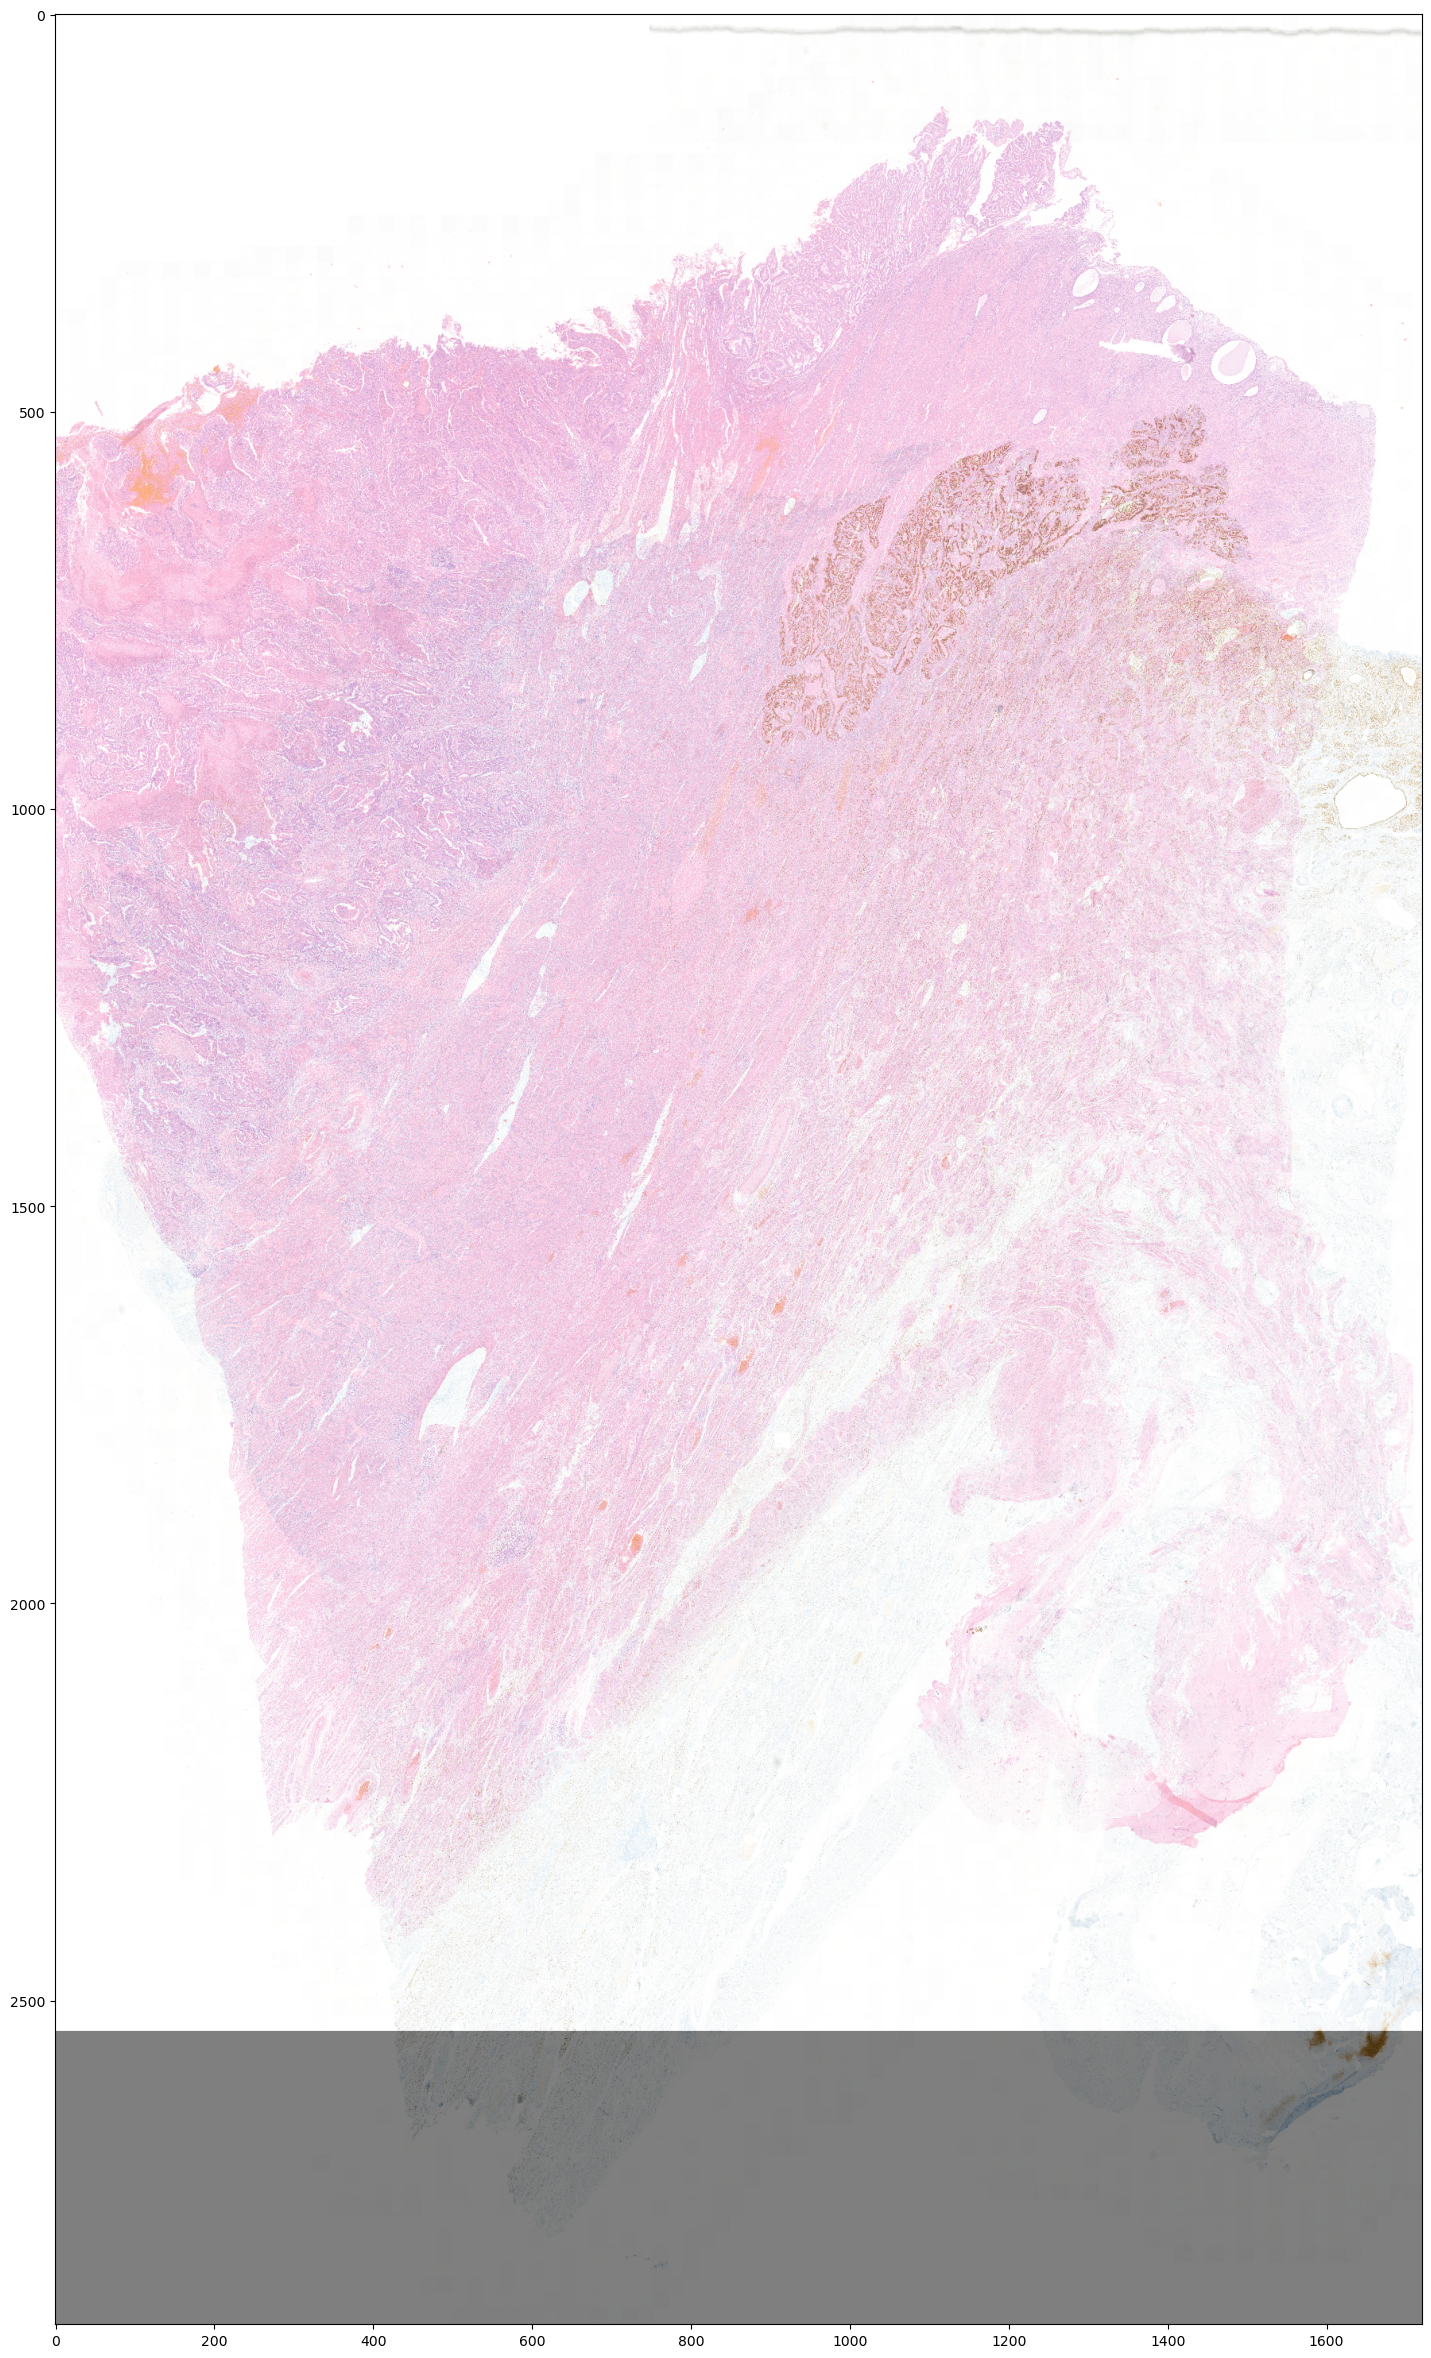

In [316]:

x=0
y=0
rotate=180
temp_he=HE_image/2
temp_protein=protein_image/2
(h, w) = temp_protein.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), rotate, 1.0)

rotated = cv2.warpAffine(temp_protein, M, (w, h))
M = np.float32([[1, 0, x], 
                [0, 1, y]])
rotated = cv2.warpAffine(rotated, M, (w, h))
if temp_protein.shape[0]> temp_he.shape[0]:
    height=temp_protein.shape[0]
else:
    height=temp_he.shape[0]
    
if temp_protein.shape[1]> temp_he.shape[1]:
    width=temp_protein.shape[1]
else:
    width=temp_he.shape[1]
    
temp_overlab=np.zeros((height,width,3))
temp_overlab[:temp_he.shape[0],:temp_he.shape[1]]+=temp_he
temp_overlab[:temp_protein.shape[0],:temp_protein.shape[1]]+=rotated
plt.figure(figsize=(30,30))
plt.imshow((temp_overlab).astype(np.uint8))

In [313]:
sample=[slide_name,stain_name,x,y,rotate]  
df.loc[count]=sample
count+=1

In [318]:
df.to_csv('../../data/100x_Transfer.csv',index=False)